In [2]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth
import branca
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPoint

In [4]:
data = pd.read_csv('example_complete.csv')

In [5]:
data.shape

(98521, 45)

In [6]:
data.drop_duplicates(keep = False, inplace = True)
data.shape

(54277, 45)

In [7]:
bogota_shp = gpd.read_file("/home/shade/DS4A/Data/Dataset/Shapes/bogota.shp")
bounds = bogota_shp.bounds

In [8]:
df_filtered = data

df_filtered = df_filtered[df_filtered['Longitude'] > bounds.minx[0]]
df_filtered = df_filtered[df_filtered['Longitude'] < bounds.maxx[0]]
df_filtered = df_filtered[df_filtered['Latitude'] > bounds.miny[0]]
df_filtered = df_filtered[df_filtered['Latitude'] < bounds.maxy[0]]

df_filtered.shape

(47888, 45)

In [9]:
data_Points =[Point(x, y) for x, y in zip(df_filtered['Longitude'], df_filtered['Latitude'])]
geo_df = gpd.GeoDataFrame(df_filtered, geometry=data_Points)

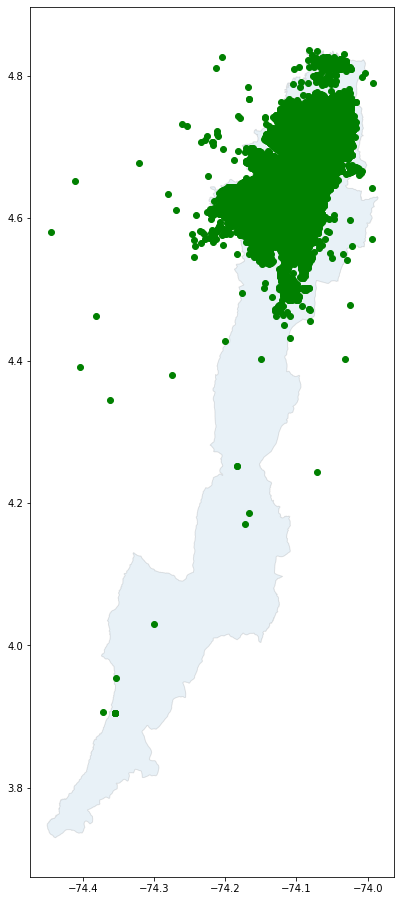

In [10]:
fig, ax = plt.subplots(figsize = (20,16))
bogota_shp.plot(figsize=(20,16), alpha=0.1, edgecolor='k', ax=ax)
geo_df.plot(figsize=(20,16), edgecolor='green', color='green', ax=ax)

In [11]:
scat_bogota_shp = gpd.read_file("/home/shade/DS4A/Data/Dataset/Shapes/SCat.shp")

In [12]:
scat_bogota_shp.shape

(1167, 6)

In [13]:
scat_bogota_shp.head()

,SCaCodigo,SCaTipo,SCaNombre,SHAPE_Leng,SHAPE_Area,geometry
0,205109,2,LA MAGDALENA I,0.030310,0.000040,POLYGON ((-74.15608478199994 4.657911440000078...
1,205227,2,OSORIO IX,0.014853,0.000013,"POLYGON ((-74.1708653199999 4.657011441000066,..."
2,208128,2,TORCA II,0.026257,0.000031,POLYGON ((-74.02644667499993 4.813648977000071...
3,105203,1,OSORIO II,0.032048,0.000035,"POLYGON ((-74.1630996909999 4.659042831000079,..."
4,201109,2,INGEMAR I,0.021199,0.000006,POLYGON ((-74.05546600899993 4.640932905000057...


In [14]:
count = []
SCaCodigo = []
SCaNombre = []

for i in range(len(scat_bogota_shp['geometry'])):
    count.append(geo_df[geo_df.intersects(scat_bogota_shp.loc[i, 'geometry'])].shape[0])
    SCaCodigo.append(scat_bogota_shp.loc[i, 'SCaCodigo'])
    SCaNombre.append(scat_bogota_shp.loc[i, 'SCaNombre'])
    if i == 250 or i == 500 or i == 750 or i == 1000:
        print (i)

250
500
750
1000


In [15]:
df = pd.DataFrame(list(zip(SCaCodigo, SCaNombre, count)), columns =['SCaCodigo', 'SCaNombre', 'count']) 
df.to_csv('count_bog_by_man_3.csv')

In [16]:
df[df['count'] == df['count'].max()]

,SCaCodigo,SCaNombre,count
236,008417,SANTA BARBARA OCCIDENTAL,1326


In [17]:
data = pd.read_csv('count_bog_by_man_3.csv')
data.head()
scat_bogota_shp['SCaCodigo'] = pd.to_numeric(scat_bogota_shp['SCaCodigo'], errors='coerce')

In [18]:
df_merge_col = pd.merge(scat_bogota_shp, data, left_on=['SCaCodigo'], right_on=['SCaCodigo'])
df_merge_col.head()

,SCaCodigo,SCaTipo,SCaNombre_x,SHAPE_Leng,SHAPE_Area,geometry,Unnamed: 0,SCaNombre_y,count
0,205109,2,LA MAGDALENA I,0.030310,0.000040,POLYGON ((-74.15608478199994 4.657911440000078...,0,LA MAGDALENA I,74
1,205227,2,OSORIO IX,0.014853,0.000013,"POLYGON ((-74.1708653199999 4.657011441000066,...",1,OSORIO IX,1
2,208128,2,TORCA II,0.026257,0.000031,POLYGON ((-74.02644667499993 4.813648977000071...,2,TORCA II,4
3,105203,1,OSORIO II,0.032048,0.000035,"POLYGON ((-74.1630996909999 4.659042831000079,...",3,OSORIO II,2
4,201109,2,INGEMAR I,0.021199,0.000006,POLYGON ((-74.05546600899993 4.640932905000057...,4,INGEMAR I,1


In [19]:
min_cn, max_cn = df_merge_col['count'].quantile([0.01,0.99]).apply(round, 2)

colormap = branca.colormap.LinearColormap(
    colors=['white','yellow','orange','red','darkred'],
    #index=beat_cn['count'].quantile([0.2,0.4,0.6,0.8]),b
    vmin=min_cn,
    vmax=max_cn
)

colormap.caption="Total houses in Bogota"

In [20]:
# interactive visualization for beat-specific crime rate in 2017

m_crime = folium.Map(location=[4.550, -74.092],
                        zoom_start=11,
                        tiles="openstreetmap")

style_function = lambda x: {
    'fillColor': colormap(x['properties']['count']),
    'color': 'black',
    'weight':2,
    'fillOpacity':0.5
}

stategeo = folium.GeoJson(
    df_merge_col.to_json(),
    name='Bogota Real State',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['SCaNombre_x', 'count'],
        aliases=['SCaNombre_x', 'Total sales'], 
        localize=True
    )
).add_to(m_crime)

colormap.add_to(m_crime)
m_crime.save('index_sec_bog_2.html')